## This notebook is for doing [dogs and cats challenge](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition)

In [1]:
import sys
sys.path.append('..')
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import math

from src.train.train_model import train_model
from src.transforms.transforms import data_transforms
from src.visualization.visualize import visualize_model

print(torch.__version__)
plt.ion()   # interactive mode

1.0.1.post2


In [2]:

# data_dir = '../data'
SUBMISSION_FILE = '../data/submission.csv'
data_dir = '../data/sample/'

CHECK_POINT_PATH = '../data/checkpoint.tar'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                              shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(class_names)
print('Train image size: {}'.format(dataset_sizes["train"]))
print('Validation image size: {}'.format(dataset_sizes["val"]))

['cats', 'dogs']
Train image size: 200
Validation image size: 40


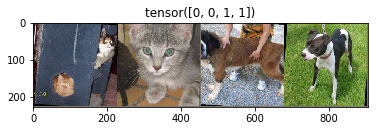

In [3]:
from src.visualization.visualize import imshow

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
sample_train_images = torchvision.utils.make_grid(inputs)

imshow(sample_train_images, title=classes)


### Use pretrained model resnet50

In [4]:
model_conv = torchvision.models.resnet50(pretrained=True)

In [5]:
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

### Train model (WITHOUT checkpoint at firts time) and save it

In [6]:
try:
    checkpoint = torch.load(CHECK_POINT_PATH)
    print("checkpoint loaded")
except:
    checkpoint = None
    print("checkpoint not found")
model_conv, best_val_loss, best_val_acc = train_model(model_conv,
                                                      criterion,
                                                      optimizer_conv,
                                                      exp_lr_scheduler,
                                                      dataloaders,
                                                      dataset_sizes,
                                                      device,
                                                      num_epochs = 3,
                                                      checkpoint = checkpoint)
torch.save({'model_state_dict': model_conv.state_dict(),
            'optimizer_state_dict': optimizer_conv.state_dict(),
            'best_val_loss': best_val_loss,
            'best_val_accuracy': best_val_acc,
            'scheduler_state_dict' : exp_lr_scheduler.state_dict(),
            }, CHECK_POINT_PATH)

checkpoint not found
Epoch 0/2
----------
train Loss: 0.4835 Acc: 0.7500
val Loss: 0.1702 Acc: 0.9750
New best model found!
New record loss: 0.17017778605222703, previous record loss: inf

Epoch 1/2
----------
train Loss: 0.5400 Acc: 0.7700
val Loss: 0.2018 Acc: 0.8500

Epoch 2/2
----------
train Loss: 0.3065 Acc: 0.8800
val Loss: 0.0638 Acc: 0.9750
New best model found!
New record loss: 0.06384159624576569, previous record loss: 0.17017778605222703

Training complete in 3m 32s
Best val Acc: 0.9750 Best val loss: 0.0638


### Visualize prediction using validation set

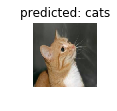

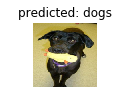

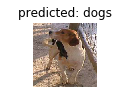

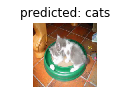

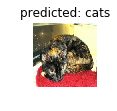

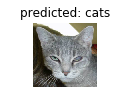

In [7]:
visualize_model(model_conv, dataloaders, device, class_names)

plt.ioff()
plt.show()

### Train model using checkpoint

In [8]:
for param in model_conv.parameters():
    param.requires_grad = True

model_conv = model_conv.to(device)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_conv.parameters(), lr=0.001, momentum=0.9)

In [9]:
try:
    checkpoint = torch.load(CHECK_POINT_PATH)
    print("checkpoint loaded")
except:
    checkpoint = None
    print("checkpoint not found")
model_conv, best_val_loss, best_val_acc = train_model(model_conv,
                                                      criterion,
                                                      optimizer_conv,
                                                      exp_lr_scheduler,
                                                      dataloaders,
                                                      dataset_sizes,
                                                      device,
                                                      num_epochs=3,
                                                      checkpoint=checkpoint)
torch.save({'model_state_dict': model_conv.state_dict(),
            'optimizer_state_dict': optimizer_conv.state_dict(),
            'best_val_loss': best_val_loss,
            'best_val_accuracy': best_val_acc,
            'scheduler_state_dict' : exp_lr_scheduler.state_dict(),
            }, CHECK_POINT_PATH)

checkpoint loaded
Val loss: 0.06384159624576569, Val accuracy: 0.975
Epoch 0/2
----------
train Loss: 0.2137 Acc: 0.9200
val Loss: 0.0601 Acc: 0.9750
New best model found!
New record loss: 0.06010969877243042, previous record loss: 0.06384159624576569

Epoch 1/2
----------
train Loss: 0.2771 Acc: 0.8900
val Loss: 0.0787 Acc: 0.9750

Epoch 2/2
----------
train Loss: 0.3417 Acc: 0.8550
val Loss: 0.1094 Acc: 1.0000

Training complete in 9m 32s
Best val Acc: 0.9750 Best val loss: 0.0601


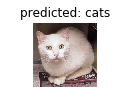

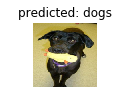

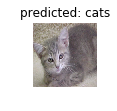

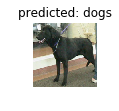

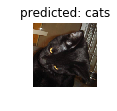

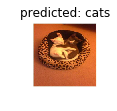

In [11]:
visualize_model(model_conv, dataloaders, device, class_names)

### Create and save submission file - csv file with predictions and its probabilities for images from testset

In [12]:
from src.predict.predict_model import apply_test_transforms, predict_dog_prob_of_single_instance, test_data_from_fname
from src.utils import extract_file_id

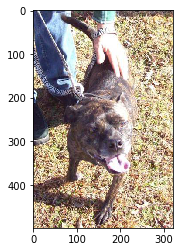

In [13]:
from PIL import Image

test_data_dir = '{}/test'.format(data_dir)
test_data_files = os.listdir(test_data_dir)
im = Image.open('{}/{}'.format(test_data_dir, test_data_files[0]))
plt.imshow(im)

In [14]:
im_as_tensor = apply_test_transforms(im)
print(im_as_tensor.size())
minibatch = torch.stack([im_as_tensor])
print(minibatch.size())

torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])


In [15]:
model_conv(minibatch)

tensor([[-2.3399,  2.7566]], grad_fn=<AddmmBackward>)

In [16]:
softMax = nn.Softmax(dim=1)
preds = softMax(model_conv(minibatch))
preds

tensor([[0.0061, 0.9939]], grad_fn=<SoftmaxBackward>)

In [17]:
extract_file_id("cat34432.jpg")

Extracting id from cat34432.jpg


34432

In [18]:
model_conv.eval()
id_to_dog_prob = {extract_file_id(fname): 
                  predict_dog_prob_of_single_instance(model_conv,
                                                      test_data_from_fname(os.path.join(test_data_dir, fname)))
                  for fname in test_data_files}

Extracting id from 176.jpg
Extracting id from 913.jpg
Extracting id from 2184.jpg
Extracting id from 11949.jpg
Extracting id from 10954.jpg
Extracting id from 3667.jpg
Extracting id from 721.jpg
Extracting id from 2340.jpg
Extracting id from 7987.jpg
Extracting id from 6452.jpg
Extracting id from 7572.jpg
Extracting id from 1098.jpg
Extracting id from 10574.jpg
Extracting id from 7972.jpg
Extracting id from 12415.jpg
Extracting id from 6409.jpg
Extracting id from 3736.jpg
Extracting id from 12284.jpg
Extracting id from 1487.jpg
Extracting id from 8031.jpg


In [19]:
import pandas as pd

ds = pd.Series({id : label for (id, label) in zip(id_to_dog_prob.keys(), id_to_dog_prob.values())})
ds.head()

176     0.993919
721     0.004930
913     0.972969
1098    0.029692
1487    0.041574
dtype: float64

In [20]:
df = pd.DataFrame(ds, columns = ['label']).sort_index()
df['id'] = df.index
df = df[['id', 'label']]
df.head()

,id,label
176,176,0.993919
721,721,0.004930
913,913,0.972969
1098,1098,0.029692
1487,1487,0.041574


In [21]:
df.to_csv(SUBMISSION_FILE, index = False)